In [294]:
import numpy as np
import random
from matplotlib import pyplot as plt

In [272]:
def relu(x):
    x[x<0] = 0.7*x[x<0] 
    return x

def drelu(x):
    a = np.zeros(x.shape)
    a[x>0] = 1
    a[x<0] = 0.7
    return a

def sigmoid(x):
    return 1.0/(1.0+np.exp(x))


def dsigmoid(x):
    return sigmoid(x)*(1.0-sigmoid(x))

In [295]:
def plot_result(model, data_test):
    plt.figure(figsize=(24,16))
    for i in range(20):
        plt.subplot(5,4,i+1)
        plt.plot(model.predict(data_test[i]))
        plt.plot(np.arange(data_test[i].shape[0])[::-1])
        plt.plot(np.zeros(data_test[i].shape[0])+5)
        plt.plot(np.zeros(data_test[i].shape[0]))
    plt.show()

In [273]:
class RNN:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.U = np.random.randn(hidden_dim, input_dim)*0.01
        self.V = np.random.randn(output_dim, hidden_dim)*0.1
        self.W = np.random.randn(hidden_dim, hidden_dim)*0.01
        self.b = np.random.randn(hidden_dim, 1)*0.01
        self.c = np.random.randn(output_dim, 1)*0.1

    def forward(self, x):
        T = x.shape[0]
        self.s = np.zeros((T+1, self.hidden_dim))
        self.o = np.zeros((T, self.output_dim))
        for i in range(T):
            self.s[i] = np.tanh(np.dot(self.U, x[i])+np.dot(self.W, self.s[i-1]) + self.b.T)
            self.o[i] = relu(np.dot(self.V, self.s[i])+self.c)

    def predict(self, x):
        T = x.shape[0]
        s = np.zeros((self.hidden_dim, 1))
        o = np.zeros((T, self.output_dim))
        for i in range(T):
            s = (np.tanh(np.dot(self.U, x[i]).reshape(self.hidden_dim,1)+np.dot(self.W, s) + self.b))
            o[i] = relu(np.dot(self.V, s) + self.c)
        return o

    def bptt(self, x, y, learning_rate=0.1, weight=False):
        T = x.shape[0]       
        if not weight:
            weight_ = np.ones(T)
        else:
            weight_ = T*np.exp(-np.arange(T)[::-1]/10.0)/np.sum(np.exp(-np.arange(T)/10.0))
        
        dLdU = np.zeros(self.U.shape)
        dLdb = np.zeros(self.b.shape)
        dLdV = np.zeros(self.V.shape)
        dLdW = np.zeros(self.W.shape)
        dLdc = np.zeros(self.c.shape)
        
        dLdo = (drelu(self.o[-1])*(y[-1]-relu(self.o[-1]))*weight_[-1]).reshape(self.output_dim,1)
        dLdh = np.dot(self.V.T, dLdo).reshape(self.hidden_dim,1)
        for t in np.arange(T)[::-1]:
            dLdV += np.dot(dLdo, self.s[t].reshape(1, self.hidden_dim))
            dLdc += dLdo
            dLdW += np.dot(np.dot(np.diag(1-self.s[t]**2), dLdh), self.s[t-1].reshape(1, self.hidden_dim))
            dLdU += np.dot(np.dot(np.diag(1-self.s[t]**2), dLdh), x[t].reshape(1, self.input_dim))
            dLdb += np.dot(np.diag(1-self.s[t]**2), dLdh)
            #next layer
            dLdo = (drelu(self.o[t-1])*(y[t-1]-relu(self.o[t-1]))*weight_[t-1]).reshape(self.output_dim,1)
            dLdh = np.dot(np.dot(self.W.T,np.diag(1-self.s[t]**2)),dLdh) + np.dot(self.V.T, dLdo)
        
        self.W += learning_rate*dLdW/T
        self.U += learning_rate*dLdU/T
        self.V += learning_rate*dLdV/T
        self.b += learning_rate*dLdb/T
        self.c += learning_rate*dLdc/T

    def emulate(self,x,y,weight):
        T = x.shape[0]       
        if not weight:
            weight_ = np.ones(T)
        else:
            weight_ = T*np.exp(np.arange(T)[::-1]/10.0)/np.sum(np.exp(np.arange(T)/10.0))
        return(np.sum(np.dot(weight_,(y.reshape(len(y),1)-self.predict(x))**2))/len(y))

    def emulate_all(self,x,y,weight):
        n = range(len(x))
        error = 0
        for i in n:
            error += self.emulate(x[i], y[i], weight)
        return error

    def fit(self, x, y, learning_rate, epoch=50, weight=False):
        n = list(range(len(x)))
        for i in range(epoch):
            random.shuffle(n)
            for j in n:
                self.forward(x[j])
                self.bptt(x[j], y[j], learning_rate, weight)

            print(self.emulate_all(x,y,weight))
            print('finish %d epoches'%i)


In [274]:
class RNN_forest:
    def __init__(self, num, input_dim, hidden_dim, output_dim):
        self.num = num
        self.output_dim = output_dim
        self.rnn = [RNN(input_dim, hidden_dim, output_dim) for _ in range(num)]
    
    def fit(self, x, y, learning_rate, epoch=50, weight=False):
        for rnn in self.rnn:
            rnn.fit(x, y, learning_rate, epoch, weight)
    
    def predict(self, x):
        y = np.zeros((x.shape[0],self.output_dim))
        for rnn in self.rnn:
            y += rnn.predict(x)
        return y/self.num
        

In [322]:
#generate data
x = 20
y = []
data = []
for i in range(x):
    sample = np.random.randn(200,20)
    sample = sample[0:np.min(np.argwhere(np.cumsum(np.sum(sample**2,1)) > 1000))]
    sample = np.column_stack((sample,np.arange(sample.shape[0])))
    data.append(sample)
    y.append(np.arange(sample.shape[0])[::-1])

In [376]:
rnn_phm = RNN(21,100,1)

In [380]:
rnn_phm.fit(data,y,0.001,50,True)

7368.57349165
finish 0 epoches
7297.77958826
finish 1 epoches
7163.51917654
finish 2 epoches
7017.4985302
finish 3 epoches
7073.04224638
finish 4 epoches
6935.23746573
finish 5 epoches
7246.89726477
finish 6 epoches
6755.93101126
finish 7 epoches
6677.73709861
finish 8 epoches
6676.84094183
finish 9 epoches
6564.98334589
finish 10 epoches
6579.20077103
finish 11 epoches
6460.88013223
finish 12 epoches
6406.04681141
finish 13 epoches
6547.22769309
finish 14 epoches
6306.43464199
finish 15 epoches
6295.17942025
finish 16 epoches
6167.23368973
finish 17 epoches
6172.19051215
finish 18 epoches
6100.01049054
finish 19 epoches
6079.55815407
finish 20 epoches
6045.8504228
finish 21 epoches
5944.57631535
finish 22 epoches
5867.18209992
finish 23 epoches
5822.52272655
finish 24 epoches
5807.05228176
finish 25 epoches
5766.35013477
finish 26 epoches
5713.25534807
finish 27 epoches
5687.22040908
finish 28 epoches
5646.41177092
finish 29 epoches
5614.39576027
finish 30 epoches
5641.76864615
finish

In [378]:
#generate test data
x = 20
y_test = []
data_test = []
for i in range(x):
    sample = np.random.randn(200,20)
    sample = sample[0:np.min(np.argwhere(np.cumsum(np.sum(sample**2,1))> 1000))]
    sample = np.column_stack((sample,np.arange(sample.shape[0])))
    data_test.append(sample)
    y_test.append(np.arange(sample.shape[0])[::-1])

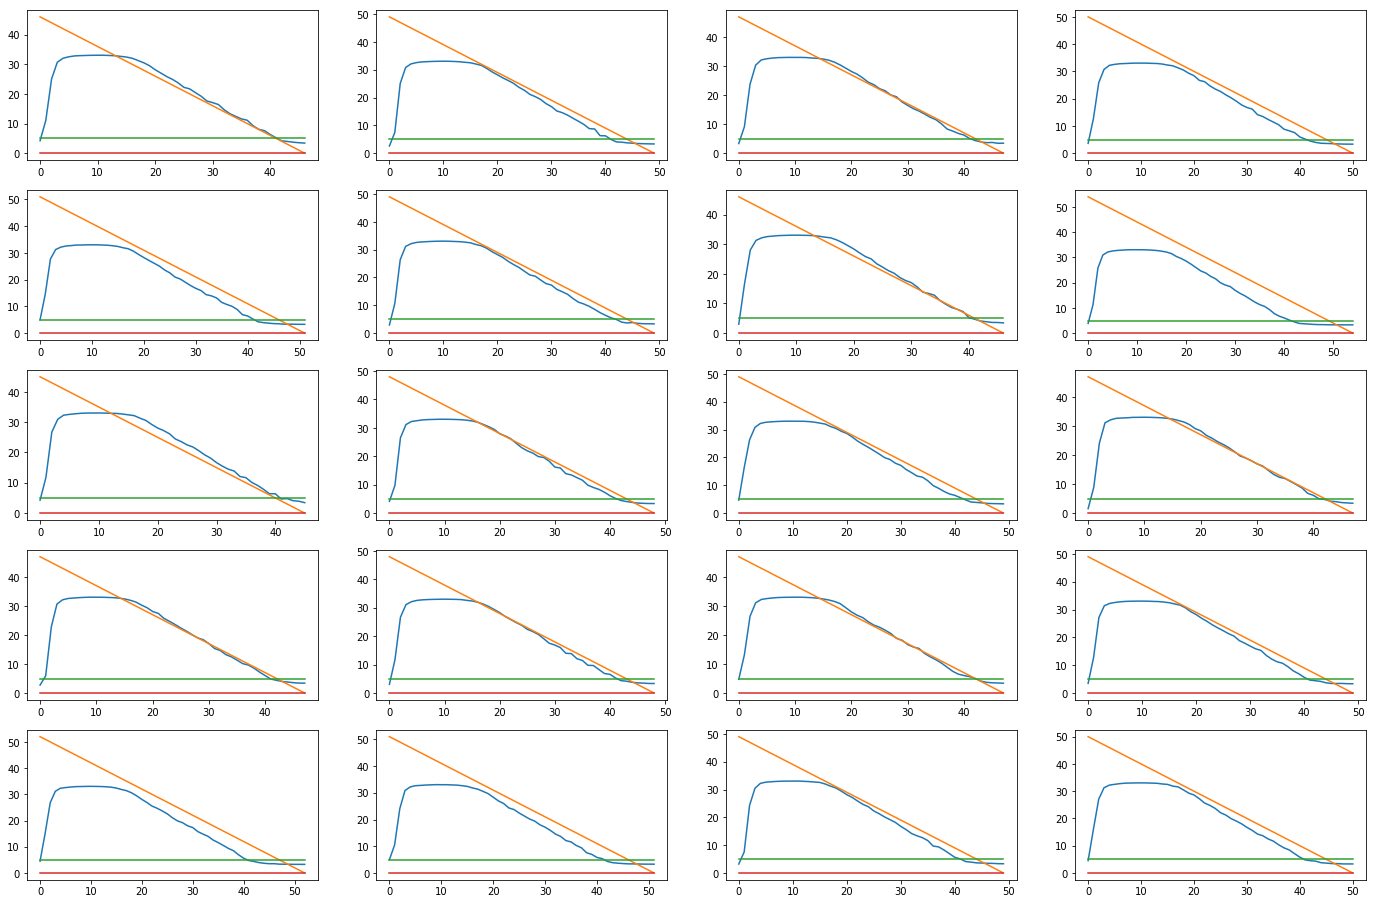

In [379]:
plot_result(rnn_phm, data_test)

In [243]:
#generate data model 2
x = 20
y = []
data = []
for i in range(x):
    sigma = np.random.random()+1
    sample = sigma*np.random.randn(200,20)
    sample = sample[0:np.min(np.argwhere(np.cumsum(np.sum(sample**2,1))>2000))]
    sample = np.column_stack((sample,np.arange(sample.shape[0])))
    data.append(sample)
    y.append(np.arange(sample.shape[0])[::-1])

In [248]:
rnn_phm_1 = RNN(21,50,1)

In [249]:
rnn_phm_1.fit(data,y,0.01,1000,True)

34578.1071965
finish 0 epoches
33660.0384674
finish 1 epoches
33626.8709738
finish 2 epoches
32604.7503477
finish 3 epoches
33482.7111966
finish 4 epoches
32050.0116866
finish 5 epoches
32400.6740156
finish 6 epoches
32143.6841507
finish 7 epoches
31624.7341516
finish 8 epoches
31597.1543535
finish 9 epoches
31699.2442677
finish 10 epoches
31440.8383809
finish 11 epoches
31752.5567703
finish 12 epoches
30443.4400597
finish 13 epoches
31997.1509201
finish 14 epoches
31966.7117758
finish 15 epoches
32328.5346187
finish 16 epoches
31936.3991778
finish 17 epoches
31232.2204195
finish 18 epoches
31791.5049546
finish 19 epoches
31469.3786587
finish 20 epoches
31195.7985042
finish 21 epoches
31475.8076983
finish 22 epoches
32162.741736
finish 23 epoches
30680.1796742
finish 24 epoches
31363.7813143
finish 25 epoches
31321.6470475
finish 26 epoches
31692.5064973
finish 27 epoches
31237.8625989
finish 28 epoches
32023.6173393
finish 29 epoches
30697.9119636
finish 30 epoches
32135.5336199
finis

22556.9705416
finish 254 epoches
23022.5295772
finish 255 epoches
23990.6003004
finish 256 epoches
22113.0645649
finish 257 epoches
22316.4362841
finish 258 epoches
20852.962501
finish 259 epoches
20457.8062982
finish 260 epoches
20241.8993342
finish 261 epoches
18502.7974664
finish 262 epoches
19975.0056366
finish 263 epoches
17554.4679987
finish 264 epoches
21446.9930589
finish 265 epoches
18248.1362928
finish 266 epoches
19132.0041473
finish 267 epoches
19558.1232025
finish 268 epoches
17616.9703437
finish 269 epoches
18003.5183518
finish 270 epoches
18281.6432213
finish 271 epoches
18414.0139685
finish 272 epoches
16644.5931817
finish 273 epoches
18832.0018479
finish 274 epoches
20095.5492614
finish 275 epoches
17806.6594681
finish 276 epoches
19928.1396494
finish 277 epoches
18105.6187976
finish 278 epoches
18039.766666
finish 279 epoches
18921.2461407
finish 280 epoches
17402.0794697
finish 281 epoches
18372.792094
finish 282 epoches
17501.3740113
finish 283 epoches
16794.4504091

15387.5711947
finish 504 epoches
15152.1559816
finish 505 epoches
18458.1447513
finish 506 epoches
16432.3757433
finish 507 epoches
18365.1528071
finish 508 epoches
15460.88369
finish 509 epoches
20558.1316659
finish 510 epoches
17609.1794021
finish 511 epoches
16202.5962592
finish 512 epoches
15636.0937945
finish 513 epoches
16283.5564283
finish 514 epoches
16741.5052322
finish 515 epoches
17359.0492927
finish 516 epoches
16972.3561582
finish 517 epoches
16160.5969949
finish 518 epoches
16104.4612222
finish 519 epoches
17548.2198287
finish 520 epoches
15909.8622241
finish 521 epoches
14943.55887
finish 522 epoches
17224.1121054
finish 523 epoches
15524.1506443
finish 524 epoches
15834.0202682
finish 525 epoches
16069.4818288
finish 526 epoches
15815.7195969
finish 527 epoches
16580.2203994
finish 528 epoches
15139.2478157
finish 529 epoches
16460.4936879
finish 530 epoches
14721.3828512
finish 531 epoches
15550.3404916
finish 532 epoches
16222.8999734
finish 533 epoches
16661.6508647


16411.3301283
finish 754 epoches
16554.3412054
finish 755 epoches
19255.3155608
finish 756 epoches
17185.7484275
finish 757 epoches
19764.80455
finish 758 epoches
17626.4980927
finish 759 epoches
18942.8525944
finish 760 epoches
19940.4418123
finish 761 epoches
17424.7664761
finish 762 epoches
17662.5852162
finish 763 epoches
17317.0489983
finish 764 epoches
20771.102971
finish 765 epoches
20130.3056184
finish 766 epoches
19040.4993397
finish 767 epoches
19849.4897509
finish 768 epoches
18520.7699225
finish 769 epoches
19294.2133177
finish 770 epoches
18747.0530311
finish 771 epoches
17393.2435471
finish 772 epoches
17411.0728809
finish 773 epoches
17939.2432553
finish 774 epoches
16161.9892171
finish 775 epoches
16796.057732
finish 776 epoches
19036.6901488
finish 777 epoches
17690.370236
finish 778 epoches
15837.8300771
finish 779 epoches
17087.935461
finish 780 epoches
16675.6622022
finish 781 epoches
15760.2810927
finish 782 epoches
18297.0723138
finish 783 epoches
21072.3820115
fi

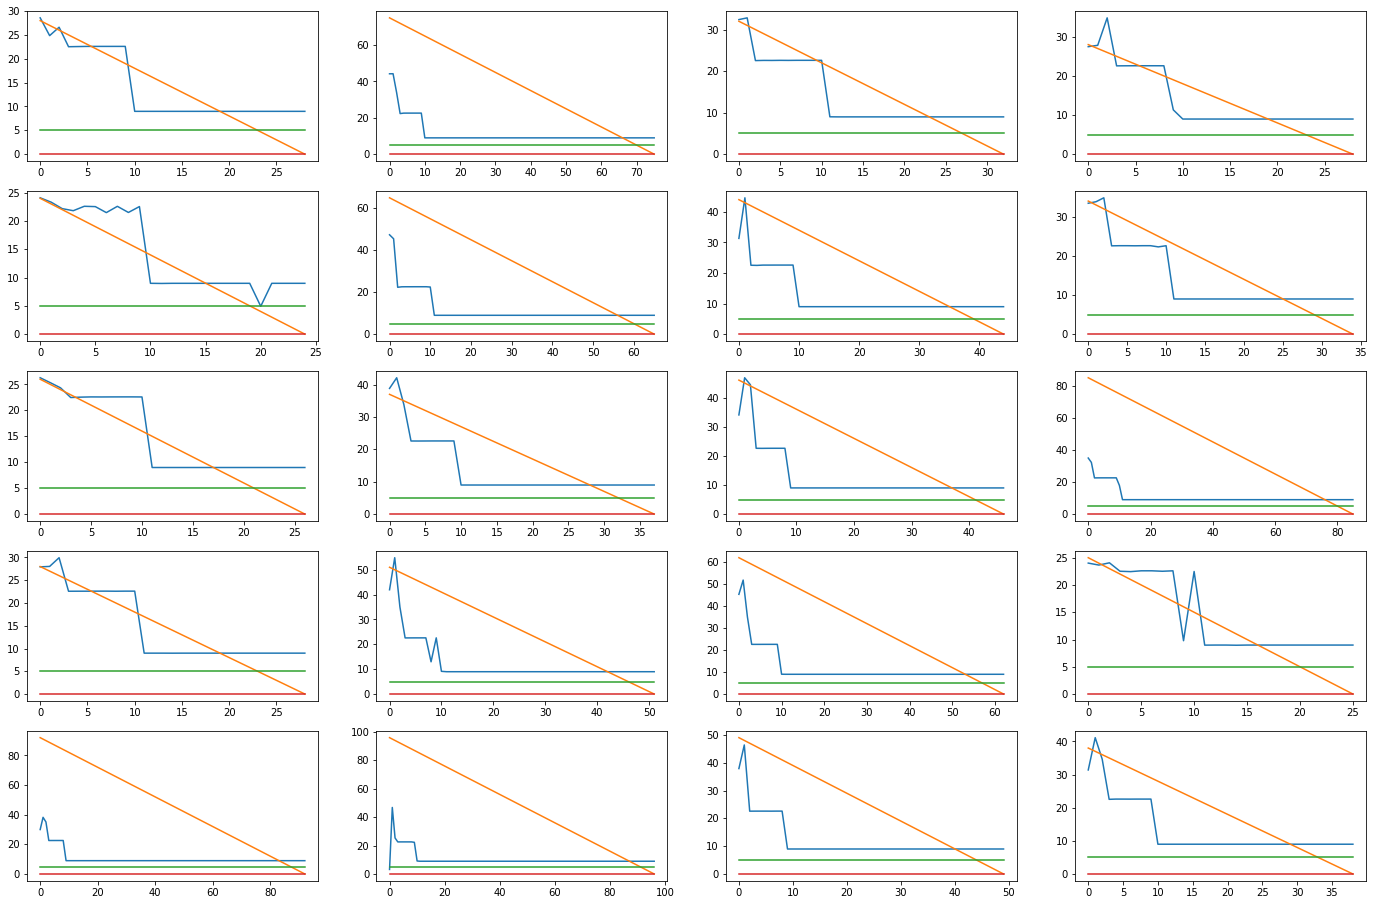

In [250]:
plot_result(rnn_phm_1, data)

In [251]:
#generate data model 3
x = 20
y = []
data = []
for i in range(x):
    sample = np.random.randn(1,20)
    while True:
        sample = np.concatenate([sample, sample[-1]+0.5*np.random.randn(1,20)])
        if np.sum(sample**2)>1500:
            break
    sample = np.column_stack((sample**2,np.arange(sample.shape[0])))
    data.append(sample)
    y.append(np.arange(sample.shape[0])[::-1])

In [257]:
rnn_phm = RNN(21,50,1)

In [258]:
rnn_phm.fit(data,y,0.01,60,True)

2399.86527533
finish 0 epoches
1774.8837067
finish 1 epoches
1997.52133688
finish 2 epoches
1969.6702288
finish 3 epoches
640.88351565
finish 4 epoches
887.671617627
finish 5 epoches
1110.1440635
finish 6 epoches
644.201180342
finish 7 epoches
522.083902135
finish 8 epoches
780.232587168
finish 9 epoches
664.049122833
finish 10 epoches
808.60597989
finish 11 epoches
540.097492935
finish 12 epoches
522.875560498
finish 13 epoches
929.435955242
finish 14 epoches
805.25832965
finish 15 epoches
582.80810782
finish 16 epoches
540.455420998
finish 17 epoches
415.261350694
finish 18 epoches
675.197391121
finish 19 epoches
401.873614792
finish 20 epoches
398.437639496
finish 21 epoches
426.139037721
finish 22 epoches
548.548490201
finish 23 epoches
555.134205635
finish 24 epoches
409.094506258
finish 25 epoches
423.303538844
finish 26 epoches
392.793197934
finish 27 epoches
384.537126675
finish 28 epoches
407.066522193
finish 29 epoches
413.242815805
finish 30 epoches
354.720399584
finish 31 e

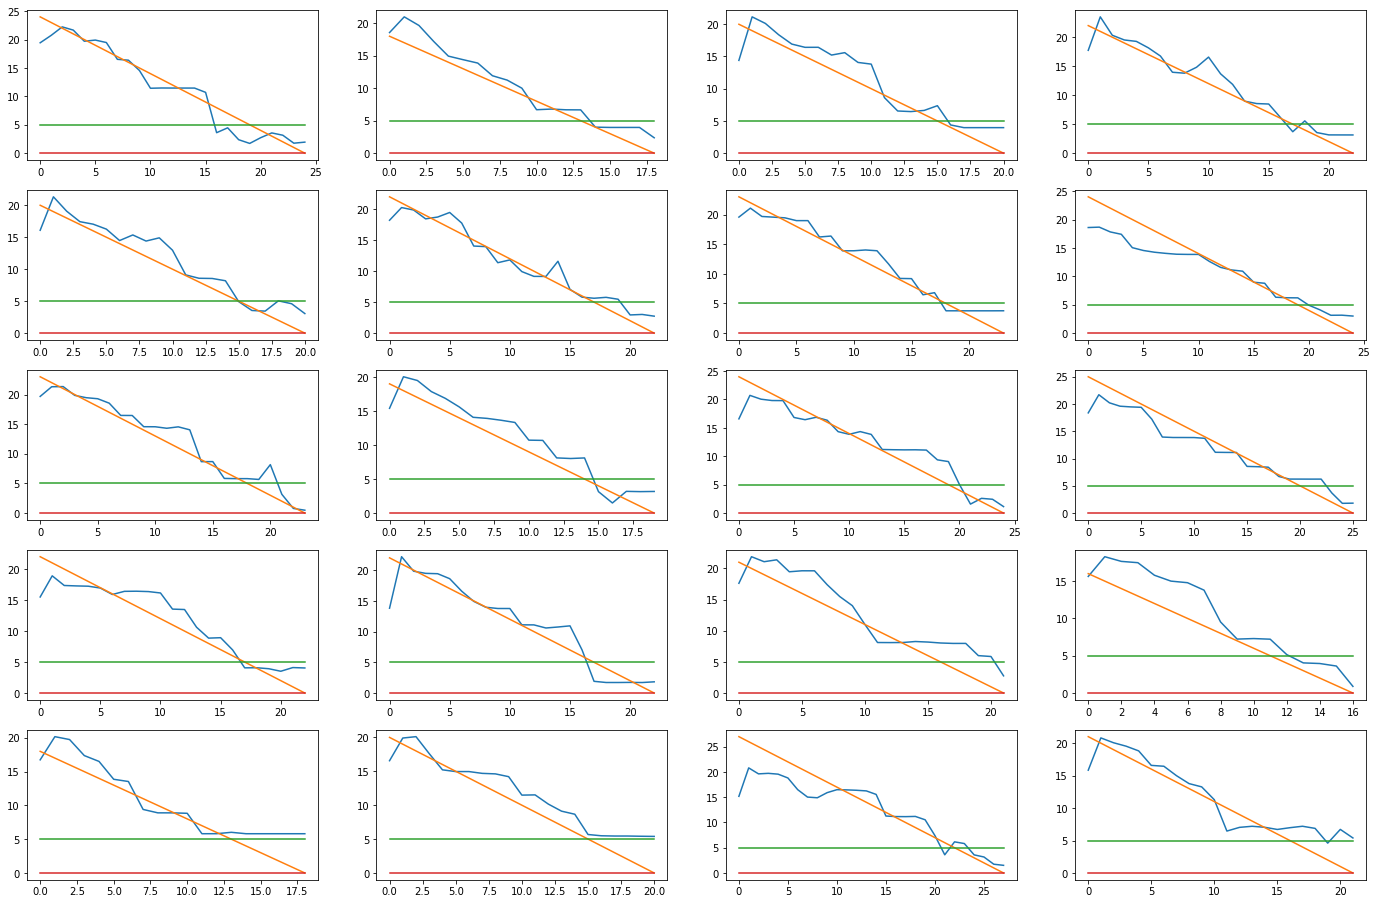

In [259]:
plot_result(rnn_phm,data)

In [260]:
#generate data model 3
x = 20
y_test = []
data_test = []
for i in range(x):
    sample = np.random.randn(1,20)
    while True:
        sample = np.concatenate([sample, sample[-1]+0.5*np.random.randn(1,20)])
        if np.sum(sample**2)>1500:
            break
    sample = np.column_stack((sample**2,np.arange(sample.shape[0])))
    data_test.append(sample)
    y_test.append(np.arange(sample.shape[0])[::-1])

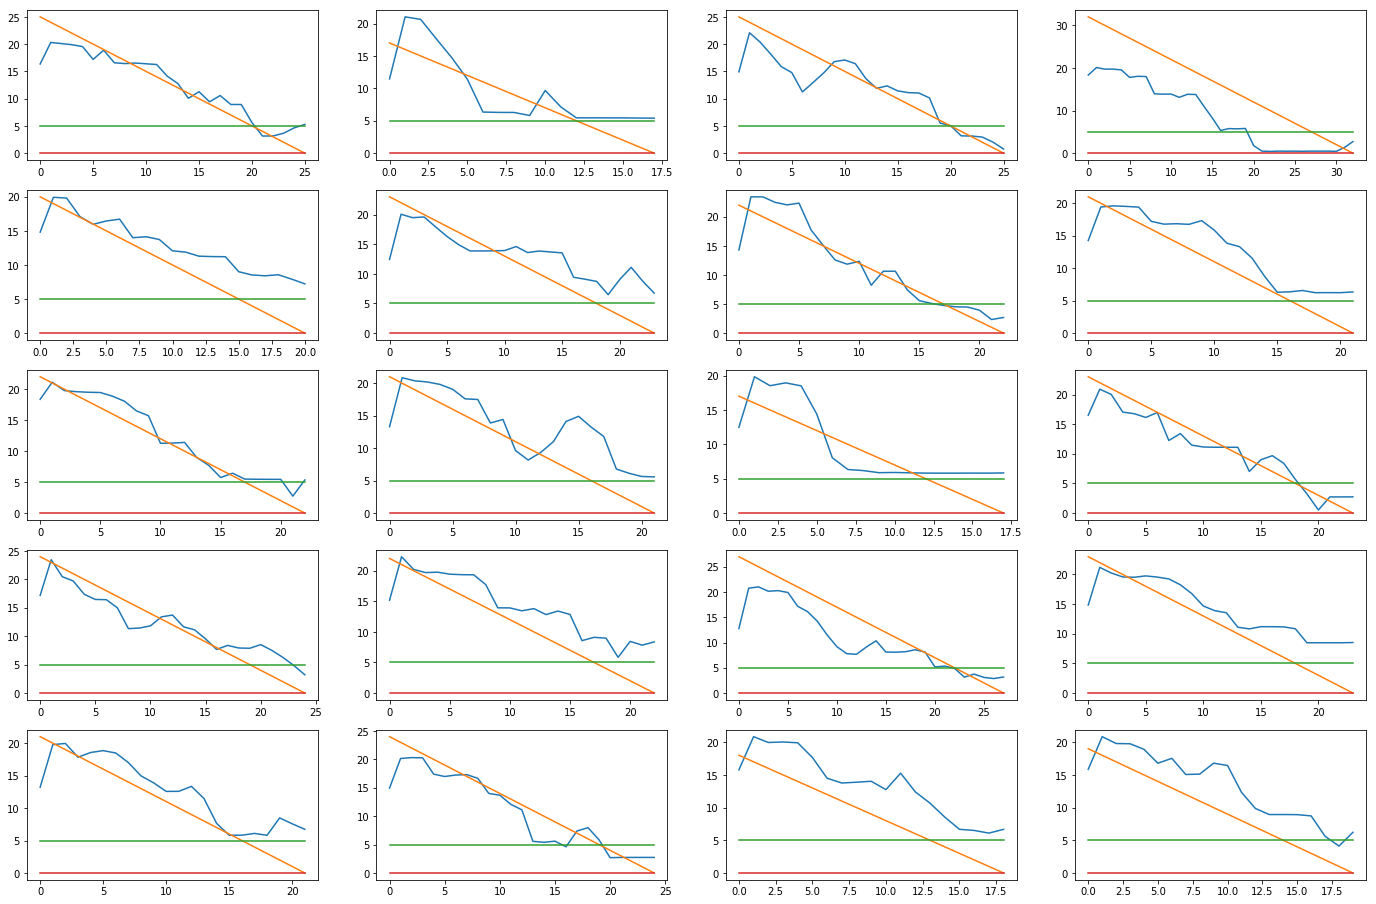

In [261]:
plot_result(rnn_phm,data_test)